In [15]:
%matplotlib inline
import h5pyd
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from scipy.interpolate import interp1d
from scipy.spatial import cKDTree

In [16]:
# Open the desired year of nsrdb data
DATA_YEAR = "2016"
nsrdb_year = h5pyd.File(f"/nrel/nsrdb/v3/nsrdb_{DATA_YEAR}.h5", 'r')
ghi = nsrdb_year['ghi']

In [17]:
# Unlike the gridded WTK data the NSRDB is provided as sparse time-series dataset.
# The quickest way to find the nearest site is using a KDtree
dset_coords = nsrdb_year['coordinates'][...]
tree = cKDTree(dset_coords)
def nearest_site(tree, lat_coord, lon_coord):
    lat_lon = np.array([lat_coord, lon_coord])
    dist, pos = tree.query(lat_lon)
    return pos

## Select Lat Long

In [18]:
FortRoss = (38.51265, -123.24647)
SanDiego = (32.648372, -117.165832)
SantaBarbara = (34.41968739792899, -119.71602929751737)
siteLocation = SantaBarbara
site_idx = nearest_site(tree, siteLocation[0], siteLocation[1] )

print("Desired Coordinates: \t {}".format(siteLocation))
print("Coordinates of nearest point: \t {}".format(dset_coords[site_idx]))
print("Site index: \t\t {}".format(site_idx))

Desired Coordinates: 	 (34.41968739792899, -119.71602929751737)
Coordinates of nearest point: 	 [  34.41 -119.7 ]
Site index: 		 87053


### Sanity Check for Selected Lat/Long

/var/folders/qc/5h73dwnj6d75cbb1b8b1r1f80000gn/T/ipykernel_6955/3482203708.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


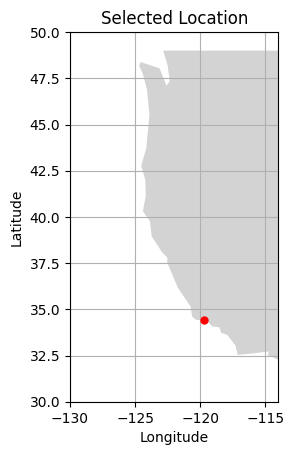

In [19]:
# Load a map of the US
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
us_map = gdf[gdf.name == "United States of America"]

# Plot the map
fig, ax = plt.subplots()
us_map.plot(ax=ax, color='lightgrey')

# Adjust the plot limits to focus on California
ax.set_xlim([-130, -114])
ax.set_ylim([30, 50])

# Plot the latitude and longitude as a point on the map
lat, lon = siteLocation
plt.plot(lon, lat, marker='o', color='red', markersize=5)
plt.title('Selected Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

Text(0.5, 1.0, 'Site ghi in 2016')

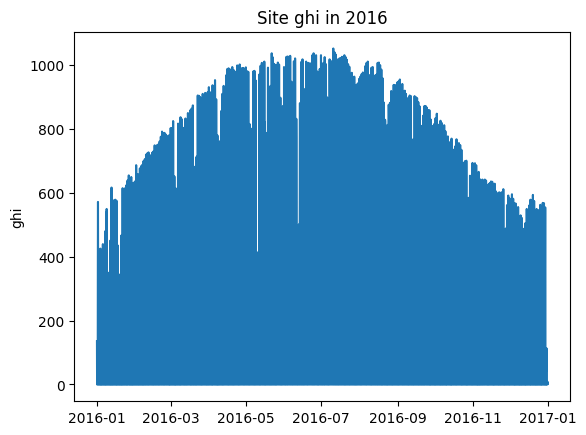

In [20]:
# Get the entire 2012 timeseries data for a point in FR
tseries = ghi[:, site_idx]
time_index = pd.to_datetime(nsrdb_year['time_index'][...].astype(str))
plt.plot(time_index, tseries)
plt.ylabel("ghi")
plt.title(f"Site ghi in {DATA_YEAR}")

In [21]:
user_specified_date = f"{DATA_YEAR}-06-20"  # Format: YYYY-MM-DD

# Convert user_specified_date to datetime
specified_date = pd.to_datetime(user_specified_date)

# Define start and end of the specified day
start_of_day = specified_date.replace(hour=0, minute=0, second=0)
end_of_day = specified_date.replace(hour=23, minute=59, second=59)

# Use boolean indexing to select data for the specified day
mask = (time_index >= start_of_day) & (time_index <= end_of_day)
day_time_index = time_index[mask]
day_tseries = tseries[mask]

print(f"time range from {start_of_day} to {end_of_day}")

# Use boolean indexing to select data for the specified date
mask = (time_index >= start_of_day) & (time_index < end_of_day)
day_time_index = time_index[mask]
day_tseries = tseries[mask]

time range from 2016-06-20 00:00:00 to 2016-06-20 23:59:59


In [22]:
day_time_index

DatetimeIndex(['2016-06-20 00:00:00', '2016-06-20 00:30:00',
               '2016-06-20 01:00:00', '2016-06-20 01:30:00',
               '2016-06-20 02:00:00', '2016-06-20 02:30:00',
               '2016-06-20 03:00:00', '2016-06-20 03:30:00',
               '2016-06-20 04:00:00', '2016-06-20 04:30:00',
               '2016-06-20 05:00:00', '2016-06-20 05:30:00',
               '2016-06-20 06:00:00', '2016-06-20 06:30:00',
               '2016-06-20 07:00:00', '2016-06-20 07:30:00',
               '2016-06-20 08:00:00', '2016-06-20 08:30:00',
               '2016-06-20 09:00:00', '2016-06-20 09:30:00',
               '2016-06-20 10:00:00', '2016-06-20 10:30:00',
               '2016-06-20 11:00:00', '2016-06-20 11:30:00',
               '2016-06-20 12:00:00', '2016-06-20 12:30:00',
               '2016-06-20 13:00:00', '2016-06-20 13:30:00',
               '2016-06-20 14:00:00', '2016-06-20 14:30:00',
               '2016-06-20 15:00:00', '2016-06-20 15:30:00',
               '2016-06-

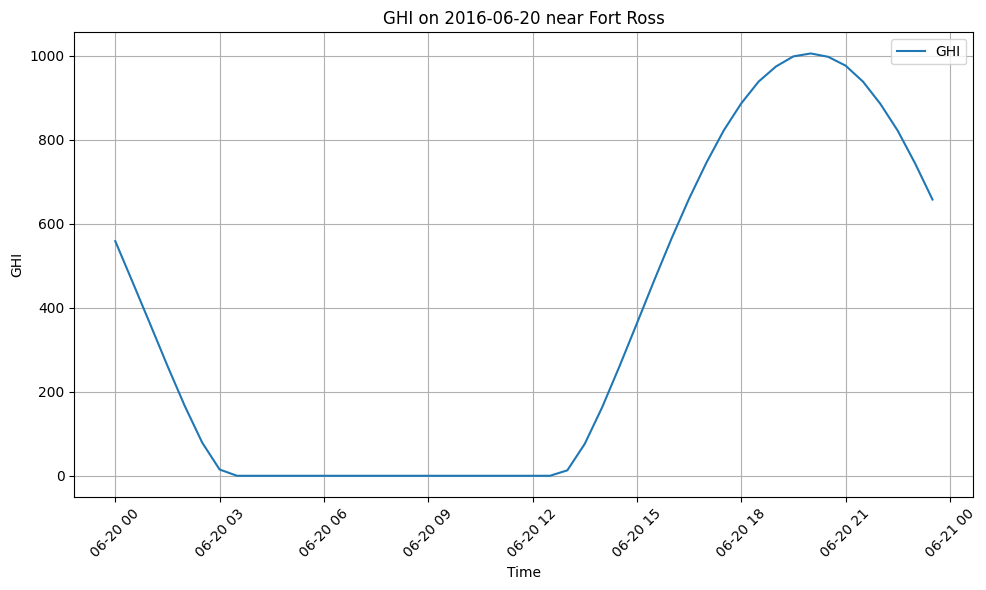

In [23]:
# Plotting the GHI for the specified day
plt.figure(figsize=(10, 6))
plt.plot(day_time_index, day_tseries, label="GHI")
plt.title(f"GHI on {user_specified_date} near Fort Ross")
plt.xlabel("Time")
plt.ylabel("GHI")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [24]:

# Define the API parameters
params = {
    'product': 'predictions',
    'application': 'NOS.COOPS.TAC.WL',
    'begin_date': '20160619',
    'end_date': '20160621',
    'datum': 'MLLW',
    'station': '9416024',  # Fort Ross station ID
    'time_zone': 'lst_ldt',
    'units': 'english',
    'interval': 'hilo',
    'format': 'json'
}

# Construct the API request URL
url = 'https://api.tidesandcurrents.noaa.gov/api/prod/datagetter'

# Sending the request
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Load data into a pandas DataFrame for analysis
    data = response.json()
    predictions = data['predictions']
    df = pd.DataFrame(predictions)
    df['t'] = pd.to_datetime(df['t'])  # Convert the time to datetime objects
    df['v'] = pd.to_numeric(df['v'])  # Convert the tide values to numeric
    print(df)
else:
    print("Failed to retrieve data:", response.status_code)


                     t      v type
0  2016-06-19 05:13:00 -0.404    L
1  2016-06-19 12:00:00  4.291    H
2  2016-06-19 16:49:00  2.634    L
3  2016-06-19 22:37:00  5.820    H
4  2016-06-20 05:47:00 -0.580    L
5  2016-06-20 12:39:00  4.405    H
6  2016-06-20 17:28:00  2.705    L
7  2016-06-20 23:13:00  5.808    H
8  2016-06-21 06:21:00 -0.705    L
9  2016-06-21 13:18:00  4.506    H
10 2016-06-21 18:08:00  2.737    L
11 2016-06-21 23:52:00  5.735    H


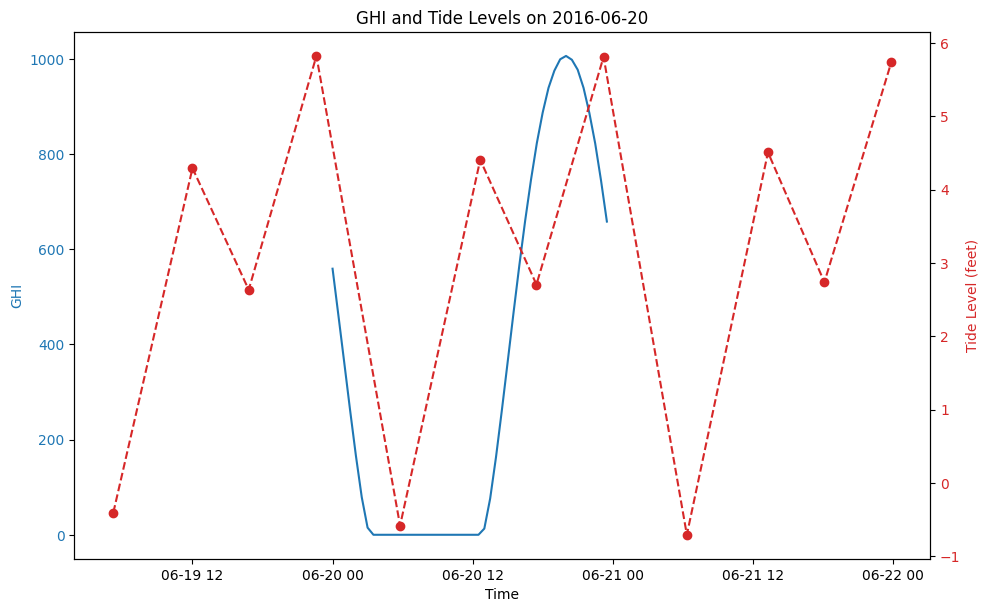

In [25]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot GHI data
ax1.plot(day_time_index, day_tseries, label='GHI', color='tab:blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('GHI', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a secondary y-axis for tide data
ax2 = ax1.twinx()
ax2.plot(df['t'], df['v'], label='Tide Level', color='tab:red', marker='o', linestyle='--')
ax2.set_ylabel('Tide Level (feet)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Optionally, add a legend or more labels
fig.tight_layout()
plt.title(f"GHI and Tide Levels on {user_specified_date}")
plt.show()

/var/folders/qc/5h73dwnj6d75cbb1b8b1r1f80000gn/T/ipykernel_6955/342499022.py:2: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  tide_times = pd.to_datetime(df['t']).view(np.int64)  # Convert to int for interpolation


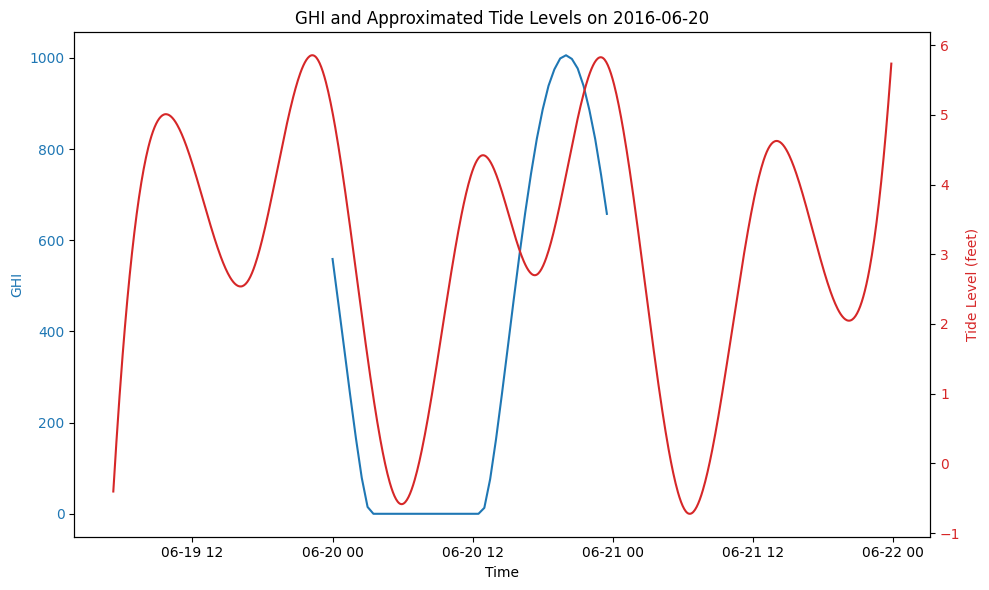

In [26]:

# Extract tide times and levels
tide_times = pd.to_datetime(df['t']).view(np.int64)  # Convert to int for interpolation
tide_levels = df['v'].values

# Create interpolation function
interpolation_func = interp1d(tide_times, tide_levels, kind='cubic')

# Generate new times from the GHI data's time range for a smoother curve
new_times = np.linspace(tide_times.min(), tide_times.max(), num=1000)
new_levels = interpolation_func(new_times)

# Convert new_times back to datetime for plotting
new_times_datetime = pd.to_datetime(new_times)

# Plotting both GHI and interpolated tide data
fig, ax1 = plt.subplots(figsize=(10, 6))

# GHI Data
ax1.plot(day_time_index, day_tseries, label='GHI', color='tab:blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('GHI', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Tide Data with Curve
ax2 = ax1.twinx()
ax2.plot(new_times_datetime, new_levels, label='Tide Level', color='tab:red')
ax2.set_ylabel('Tide Level (feet)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title(f"GHI and Approximated Tide Levels on {user_specified_date}")
plt.tight_layout()
plt.show()
